# Optic Disc Segmentation

In [1]:
%matplotlib inline

import os
import os.path
import cv2
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['figure.dpi'] = 300

## Load the Images
Note to self: for consistency across platforms within my own repository structure, always run `jupyter notebook` from the root of this git repo `COMP9517`.

In [2]:
# repo_path = os.getcwd()
# data_path = os.path.join(repo_path, "assignments", "ass2", "Data_Individual_Component")

# retinal_images_path = os.path.join(data_path, "original_retinal_images")
# truth_masks_path = os.path.join(data_path, "optic_disc_segmentation_masks")

retinal_images_path = os.path.join("Data_Individual_Component", "original_retinal_images")
truth_masks_path = os.path.join("Data_Individual_Component", "optic_disc_segmentation_masks")

def get_mask_name(image_name):
    basename = os.path.splitext(image_name)[0]
    return basename + '_OD.tif'
    

image_names = os.listdir(retinal_images_path) 
mask_names = list(map(get_mask_name, image_names))

retinal_images_names = list(map(lambda x: os.path.join(retinal_images_path, x), image_names))
truth_masks_names = list(map(lambda x: os.path.join(truth_masks_path, x), mask_names))

df = pd.DataFrame({"image_path": retinal_images_names, "mask_path": truth_masks_names})

## Read the image

In [3]:
from skimage.morphology import extrema

sample = df.sample(1).iloc[0,:]

orig_img = cv2.imread(sample["image_path"])
mask = cv2.imread(sample["mask_path"])

In [4]:
print(sample["image_path"])
print(sample["mask_path"])

Data_Individual_Component/original_retinal_images/IDRiD_03.jpg
Data_Individual_Component/optic_disc_segmentation_masks/IDRiD_03_OD.tif


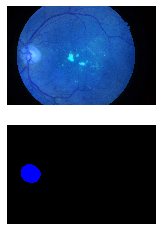

In [5]:
# downscale the image

height = 1046
width = int(1046 * orig_img.shape[1] / orig_img.shape[0])

orig_img = cv2.resize(orig_img, (width, height))
mask = cv2.resize(mask, (width, height))

img = np.copy(orig_img)

fig, axes = plt.subplots(2,1)
axes[0].axis("off")
axes[1].axis("off")

axes[0].imshow(img)
axes[1].imshow(mask)


## Average Filter and Split into Channels

In [6]:
# apply average filter to reduce effect of noise
avg_filter_size = 15
avg_kernel = np.ones((avg_filter_size, avg_filter_size), np.float32) / avg_filter_size ** 2
img = cv2.filter2D(img, -1, avg_kernel)

b = img[:,:,0]
g = img[:,:,1]
r = img[:,:,2]

## Contrast Stretching

In [7]:
# perform contrast stretching
def contrast_stretch(x):
    inmax = 135
    if x >= inmax:
        return 255
    
    if x < 10:
        return 0

    return int(x * 255/inmax)

stretched = np.array([[contrast_stretch(pixel) for pixel in row] for row in g], dtype=np.uint8)

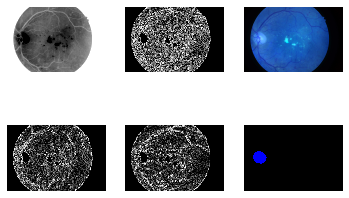

In [8]:
from scipy import ndimage as ndi


stretched_inverted = (np.ones(stretched.shape, dtype=np.uint8) * 255) - stretched

sobel_x = cv2.Sobel(stretched_inverted, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(stretched_inverted, cv2.CV_64F, 0, 1, ksize=5)

sobel_x = np.absolute(sobel_x)
sobel_x = np.uint8(sobel_x)

sobel_y = np.absolute(sobel_y)
sobel_y = np.uint8(sobel_y)

fig, axes = plt.subplots(2,3)

gradient = sobel_y + sobel_x


for axe in axes:
    for ax in axe:
        ax.axis('off')


axes[0,0].imshow(stretched_inverted, cmap='gray', vmin=0, vmax=255)
axes[0,1].imshow(gradient, cmap='gray', vmin=0, vmax=255)
axes[0,2].imshow(img, cmap='gray')

axes[1,0].imshow(sobel_x, cmap='gray')
axes[1,1].imshow(sobel_y, cmap='gray')
axes[1,2].imshow(mask, cmap='gray')

## Alternate Methods

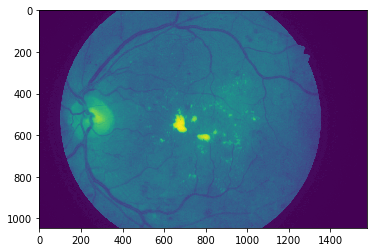

In [9]:
img2 = np.copy(orig_img)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2_g = img2[:,:,1]
plt.imshow(img2_g)

(1046, 1574)


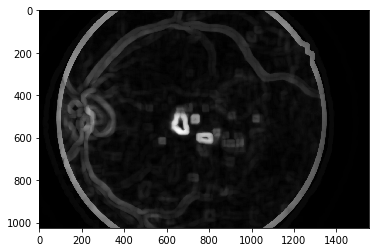

In [10]:
# Maximum difference model
filtered = cv2.medianBlur(img2_g, ksize=21)

window_size = 21

sh = filtered.shape
print(sh)
shape = (sh[0] - window_size, sh[1] - window_size)

windows = []

for row in range(shape[0]):
    for col in range(shape[1]):
        roi = filtered[row:row+window_size,col:col+window_size]
        windows.append(roi)
        
windows = np.array(windows, dtype=np.uint8)
        
maxes = np.max(windows, axis=(1,2))
mins = np.min(windows, axis=(1,2))
differences = maxes-mins
differences = np.reshape(differences, shape)

plt.imshow(differences, cmap='gray')

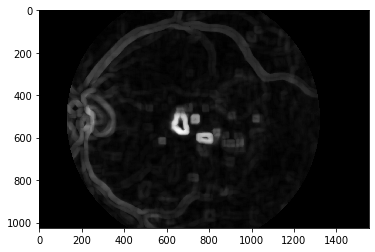

In [11]:
def showImage(name, image):
    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# bounding box of retina
thresh, bw = cv2.threshold(differences, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

left_edge = 100
while left_edge < shape[1]:
    col = bw[:,left_edge]
    if max(col) > 0:
        break
    left_edge += 1
    
right_edge = shape[1] - 1
while right_edge > 0:
    col = bw[:,right_edge]
    if max(col) > 0:
        break
    right_edge -= 1

border_thickness = 30
    
midline = int((left_edge+right_edge)/2)
radius = int((right_edge-left_edge)/2) - border_thickness
centre = midline, int(shape[0]/2)

mask = np.array(cv2.circle(np.zeros(shape), centre, radius, 1, -1, cv2.FILLED), dtype=np.uint8)
masked = cv2.bitwise_and(differences, differences, mask=mask)

_,_,_,max_loc_diff = cv2.minMaxLoc(masked)

debug_img = np.copy(differences)
debug_img = cv2.circle(debug_img, max_loc_diff, 5, 255, 2, cv2.FILLED)

showImage("Human Eyes", debug_img)

plt.imshow(masked, cmap='gray')

In [18]:
windows_71 = []

for row in range(shape[0]):
    for col in range(shape[1]):
        roi = filtered[row:row+window_size,col:col+window_size]
        windows_71.append(roi)
        
windows_71 = np.array(windows_71, dtype=np.uint8)


variances = np.var(windows_71, axis=(1,2))
variances = np.reshape(variances, shape)
variances = np.multiply(variances, mask)

In [13]:
_,_,_,max_loc_var = cv2.minMaxLoc(variances)
debug_img = cv2.circle(debug_img, max_loc_var, 10, 255, 2, cv2.FILLED)
showImage("human eyes", debug_img)

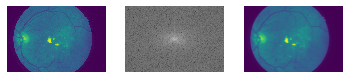

In [14]:
# Low Pass Filter

img3 = np.copy(orig_img)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3_g = img3[:,:,1]

f = np.fft.fft2(img3_g)
fshift = np.fft.fftshift(f)

shape_2 = img3_g.shape

magnitude_spectrum = 20 * np.log(np.abs(fshift))

centre_point = shape_2[0]/2, shape_2[1]/2

# low pass gaussian filter in frequency domain with cutoff
cutoff = 25 # cutoff in hz
for row in range(shape_2[0]):
    for col in range(shape_2[1]):
        dist = np.linalg.norm(np.array(centre_point) - np.array((row,col)))
        fshift[row,col] = fshift[row,col] * np.exp(-(dist**2)/((2*cutoff)**2))

f_ishift = np.fft.ifftshift(fshift)
reconstructed = np.fft.ifft2(f_ishift)
reconstructed = np.real(reconstructed)

fig, axes = plt.subplots(1,3)

_,_,_,max_loc_lpg = cv2.minMaxLoc(reconstructed)

debug_img = cv2.circle(debug_img, max_loc_lpg, 20, 255, 2, cv2.FILLED)

axes[0].axis('off')
axes[0].imshow(img2_g)
axes[1].axis('off')
axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[2].axis('off')
axes[2].imshow(reconstructed)

In [15]:
showImage("thirdPoint", debug_img)

# Testing

In [16]:
def test_segmentation(image_path, truth_path):

    retinal_img = cv2.imread(image_path)
    truth_img = cv2.imread(truth_path)

    retinal_img = cv2.resize(retinal_img, None, fx=1, fy=1)

    segmented_img, max_diff_loc = segment(retinal_img)

    fig, axes = plt.subplots(1, 3)
    
    for ax in axes:
        ax.axis('off')
    
    axes[0].imshow(retinal_img)
    axes[1].imshow(truth_img)
    axes[2].imshow(segmented_img)
    
    pass

NameError: name 'segment' is not defined